In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU is available')
    !nvidia-smi
else:
    print('GPU is not available')

2024-04-28 13:05:52.405159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 13:05:52.405265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 13:05:52.556942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available
Sun Apr 28 13:06:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              28W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------

In [2]:

import os
import numpy as np
from skimage.color import rgb2lab
from skimage.io import imread
from skimage.transform import resize

# Path to the directory containing the images
directory = '/kaggle/input/dataset-3/dataset'

# Initialize empty lists for X and Y
X = []
Y = []

# Iterate over each image in the directory
for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust file extensions as needed
        # Read the image
        img = imread(os.path.join(directory, filename))

        # Normalize the image (divide by 255)
        img_normalized = img / 255.0

        # Resize the image if needed (optional)
        img_resized = resize(img_normalized, (128, 128))  # Specify desired dimensions

        # Convert from RGB to Lab
        lab = rgb2lab(img_resized)

        # Append L channel to X
        X.append(lab[:, :, 0])

        # Append ab channels, normalized, to Y
        Y.append(lab[:, :, 1:] / 128)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Reshape X to include channel dimension
X = X.reshape(X.shape + (1,))
print(X.shape,Y.shape)

(1800, 128, 128, 1) (1800, 128, 128, 2)


In [6]:
from keras.layers import Input, Concatenate, Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

# Encoder
encoder_input = Input(shape=(128, 128, 1))
encoder_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_conv1)
encoder_conv3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_conv2)
encoder_conv4 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_conv3)
encoder_conv5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_conv4)
encoder_conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_conv5)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', strides=2)(encoder_conv6)

# Decoder
decoder_conv1 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
decoder_upsample1 = UpSampling2D((2, 2))(decoder_conv1)
decoder_conv2 = Conv2D(256, (3,3), activation='relu', padding='same')(decoder_upsample1)
decoder_upsample2 = UpSampling2D((2, 2))(decoder_conv2)
decoder_conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_upsample2)
decoder_upsample3 = UpSampling2D((2, 2))(decoder_conv3)
decoder_conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_upsample3)
decoder_upsample4 = UpSampling2D((2, 2))(decoder_conv4)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_upsample4)

# Combine encoder and decoder into a single model
model = Model(inputs=encoder_input, outputs=decoder_output)

# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse' , metrics=['accuracy'])

# Print model summary
model.summary()

# Fit the model
model.fit(X, Y, validation_split=0.1, epochs=100, batch_size=16)

# Save the model
# model.save('other_files/colorize_autoencoder.model')


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 128, 128, 2)    │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,556,994 (32.64 MB)

 Trainable params: 8,556,994 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.5310 - loss: 0.1206 - val_accuracy: 0.5618 - val_loss: 0.0141
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5864 - loss: 0.0137 - val_accuracy: 0.5721 - val_loss: 0.0141
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5889 - loss: 0.0145 - val_accuracy: 0.5586 - val_loss: 0.0147
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5882 - loss: 0.0139 - val_accuracy: 0.5626 - val_loss: 0.0143
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6017 - loss: 0.0151 - val_accuracy: 0.5875 - val_loss: 0.0138
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5843 - loss: 0.0140 - val_accuracy: 0.5586 - val_loss: 0.0143
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5822 - loss: 0.0150 - val_accuracy: 0.5835 - val_loss: 0.0140
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5969 - loss: 0.0142 -

In [10]:
model.save('my_model.keras')

In [11]:
new_model = tf.keras.models.load_model('/kaggle/input/model/my_model (1).keras')

# Show the model architecture
new_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 64, 64,    │        640 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 64, 64,    │     73,856 │ conv2d_96[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_97[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 32, 32,    │    295,168 │ conv2d_98[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 16, 16,    │    590,080 │ conv2d_99[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ conv2d_100[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 8, 8, 512) │  2,359,808 │ conv2d_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 8, 8, 512) │  2,359,808 │ conv2d_102[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_32    │ (None, 16, 16,    │          0 │ conv2d_103[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 16, 16,    │          0 │ up_sampling2d_32… │
│ (Concatenate)       │ 768)              │            │ conv2d_100[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 16, 16,    │  1,769,728 │ concatenate_24[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_33    │ (None, 32, 32,    │          0 │ conv2d_104[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 32, 32,    │          0 │ up_sampling2d_33… │
│ (Concatenate)       │ 384)              │            │ conv2d_98[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 32, 32,    │    442,496 │ concatenate_25[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_34    │ (None, 64, 64,    │          0 │ conv2d_105[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 64, 64,    │          0 │ up_sampling2d_34… │
│ (Concatenate)       │ 192)              │            │ conv2d_96[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,662,278 (71.19 MB)

 Trainable params: 9,331,138 (35.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,331,140 (35.60 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


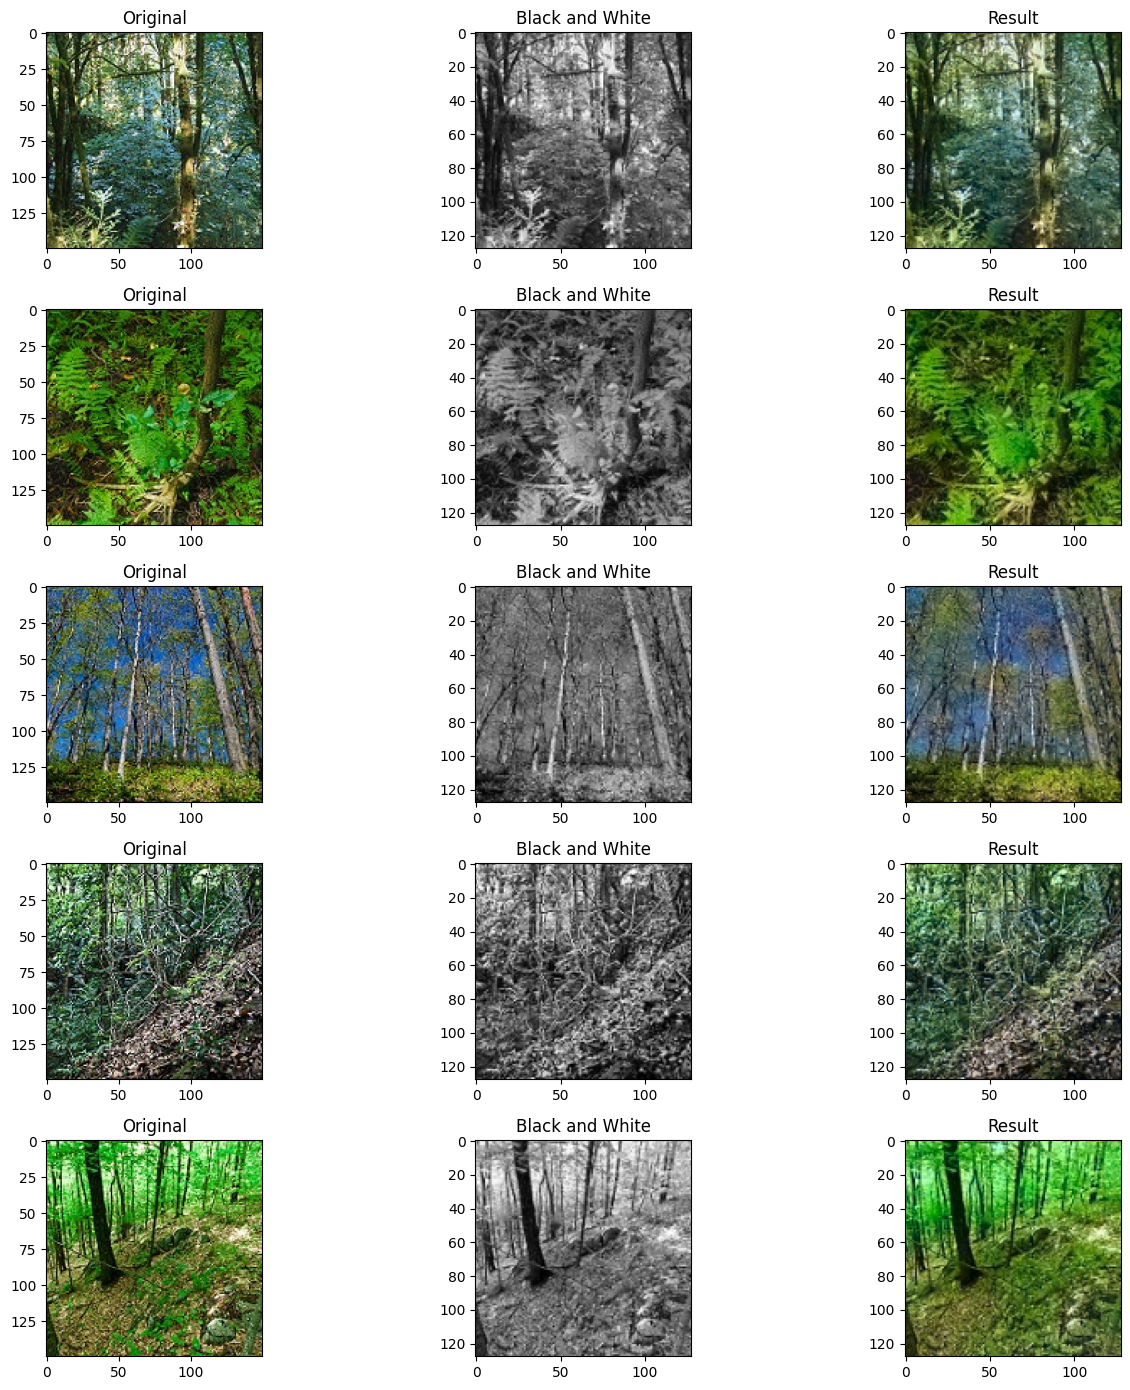

In [18]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from skimage.color import rgb2lab, lab2rgb

# Create subplots for 5 images in a grid with smaller size
fig, axs = plt.subplots(5, 3, figsize=(14, 14))
files = os.listdir("/kaggle/input/dataset-3/dataset")

# Select 5 random images from the list
selected_images = np.random.choice(files, 5, replace=False)
# Iterate over each selected image
for i, selected_image in enumerate(selected_images):
    # Load and preprocess the image
    img_color=[]
    img_path = os.path.join('/kaggle/input/dataset-3/dataset', selected_image)
    img = img_to_array(load_img(img_path))
    img = resize(img, (128, 128))
    img_color.append(img)
#     img_color = []

    # Convert the image to Lab color space
    img_color = np.array(img_color, dtype=float)
    img_color = rgb2lab(1.0/255 * img_color)[:,:,:,0]
    img_color = img_color.reshape(img_color.shape + (1,))

    # Predict the result using the model
    output = new_model.predict(img_color)
    output = output * 128

    # Create result image
    result = np.zeros((128, 128, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    # Plot original image
    axs[i, 0].imshow(load_img(img_path))
    axs[i, 0].set_title("Original")

    # Plot black and white image
    axs[i, 1].imshow(img_color[0][:, :, 0], cmap='gray')
    axs[i, 1].set_title("Black and White")

    # Plot result image
    axs[i, 2].imshow(lab2rgb(result))
    axs[i, 2].set_title("Result")
# Show the plot
plt.tight_layout()
plt.show()


In [15]:

img1_color=[]
path_test = "/kaggle/input/iit-jodhpur/IIT-Jodhpur_2.jpg"
img1=img_to_array(load_img(path_test))
img1 = resize(img1 ,(128,128))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
# plt.imshow(np.transpose(img1_color, (1, 2, 0)))
# plt.show()
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = new_model.predict(img1_color)
output1 = output1*128

result = np.zeros((128, 128, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


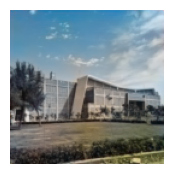

In [16]:
# Create a new figure with a smaller size
plt.figure(figsize=(2, 2))

# Display the image
plt.imshow(lab2rgb(result))

# Hide the axes
plt.axis('off')

# Show the plot
plt.show()